In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings("ignore")
from pandas import datetime
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel

In [2]:
df_final = pd.DataFrame.from_csv('~\\df_final.csv')

In [3]:
df_final= df_final[::-1]

In [4]:
X_train = df_final.drop(['Close: t'], axis=1).values[7:]
X_test = df_final.drop(['Close: t'], axis=1).values[:7]
y_train = df_final['Close: t'].values[7:]
y_test = df_final['Close: t'].values[:7]
cols = df_final.drop(['Close: t'], axis=1).columns

In [5]:
rf_feat = RandomForestRegressor(n_jobs=-1, criterion='mae', random_state=4)
start = time()

rf_feat.fit(X_train,y_train)

stop = time()
print("Elapsed_time: {}".format(stop - start))

Elapsed_time: 2.2668159008026123


In [6]:
# Feature Importance
for variable, score in sorted(zip(rf_feat.feature_importances_, cols),reverse=True):
    print(variable, score)

0.0728837019307 Volume: t-5
0.0525624604866 Volume: t-1
0.0523454332674 Close: t-5
0.0446037653622 Close: t-1
0.0382588524027 Close: t-2
0.0374538000963 Volume: t-4
0.0353640623381 Close: t-4
0.0347635360222 Google Trends: t-2
0.0346431375492 Volume: t
0.0307614660581 Google Trends: t-1
0.0306807511134 Google Trends: t-4
0.0294647827831 Google Trends: t-3
0.0291450717893 Volume: t-3
0.0270261682433 Created_At: t-2
0.0263695224703 Close: t-3
0.0243945557627 Volume: t-2
0.0221729919623 Google Trends: t-5
0.0203509262045 Created_At: t-1
0.0201051028507 Google Trends: t
0.0171757786952 Created_At: t
0.0167174742334 Created_At: t-4
0.0143338778944 Avg Retweet: t-3
0.0143250061776 Comments_Count: t
0.0122175009927 Created_At: t-3
0.011581563468 Comments_Count: t-2
0.010040742995 Avg Retweet: t-4
0.00952793963125 Avg favorite_count: t-5
0.00951128923495 Sum of favorite_count: t
0.00916945896705 Created_At: t-5
0.00887010516037 Sum of favorite_count: t-2
0.00858456990887 Sum of retweet_count: 

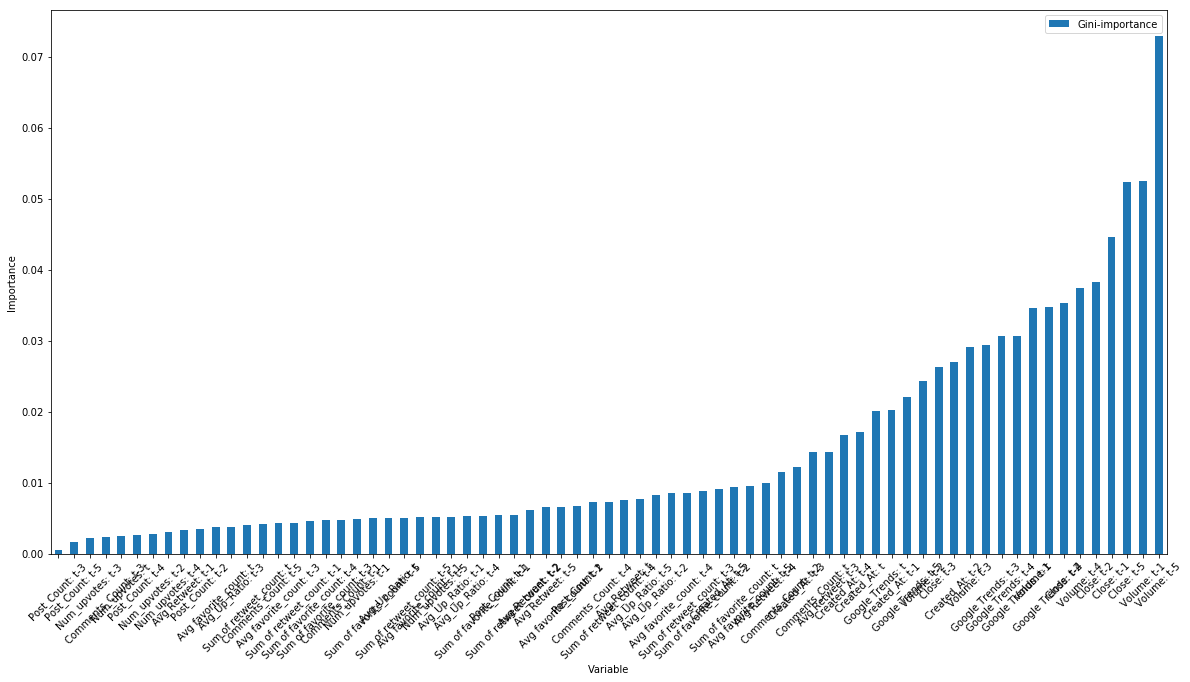

In [7]:
feats = {} # a dict to hold feature_name: feature_importance
for variable, score in sorted(zip(cols, rf_feat.feature_importances_),reverse=True):
    feats[variable] = score #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ax = importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45, figsize=(20, 10))
ax.set_ylabel('Importance')
ax.set_xlabel('Variable')

plt.show()

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
# SVM with Feature Importance without sliding window 
thresholds = np.sort(rf_feat.feature_importances_)
for thresh in thresholds:
    # selecting features using threshold
    selection = SelectFromModel(rf_feat, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # training model
    # Fit regression model
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

    # Predict
    select_X_test = selection.transform(X_test)
    y_pred = svr_rbf.fit(select_X_train, y_train).predict(select_X_test)

    # Measure Accuracy
    accuracy_rbf = mean_absolute_percentage_error(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_rbf))

Thresh=0.001, n=71, Accuracy: 162.06%
Thresh=0.002, n=70, Accuracy: 162.06%
Thresh=0.002, n=69, Accuracy: 162.06%
Thresh=0.002, n=68, Accuracy: 162.06%
Thresh=0.002, n=67, Accuracy: 162.06%
Thresh=0.003, n=66, Accuracy: 162.06%
Thresh=0.003, n=65, Accuracy: 162.06%
Thresh=0.003, n=64, Accuracy: 162.06%
Thresh=0.003, n=63, Accuracy: 162.06%
Thresh=0.004, n=62, Accuracy: 162.06%
Thresh=0.004, n=61, Accuracy: 162.06%
Thresh=0.004, n=60, Accuracy: 162.06%
Thresh=0.004, n=59, Accuracy: 162.06%
Thresh=0.004, n=58, Accuracy: 162.06%
Thresh=0.004, n=57, Accuracy: 162.06%
Thresh=0.004, n=56, Accuracy: 162.06%
Thresh=0.005, n=55, Accuracy: 162.06%
Thresh=0.005, n=54, Accuracy: 162.06%
Thresh=0.005, n=53, Accuracy: 162.06%
Thresh=0.005, n=52, Accuracy: 162.06%
Thresh=0.005, n=51, Accuracy: 162.06%
Thresh=0.005, n=50, Accuracy: 162.06%
Thresh=0.005, n=49, Accuracy: 162.06%
Thresh=0.005, n=48, Accuracy: 162.06%
Thresh=0.005, n=47, Accuracy: 162.06%
Thresh=0.005, n=46, Accuracy: 162.06%
Thresh=0.005

In [10]:
# ADA with Feature Importance without sliding window 
thresholds = np.sort(rf_feat.feature_importances_)
for thresh in thresholds:
    # selecting features using threshold
    selection = SelectFromModel(rf_feat, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # training model
    # Fit regression model
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=42)

    # Predict
    select_X_test = selection.transform(X_test)
    y_pred = ada.fit(select_X_train, y_train).predict(select_X_test)

    # Measure Accuracy
    accuracy_rbf = mean_absolute_percentage_error(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_rbf))

Thresh=0.001, n=71, Accuracy: 254.63%
Thresh=0.002, n=70, Accuracy: 268.44%
Thresh=0.002, n=69, Accuracy: 264.85%
Thresh=0.002, n=68, Accuracy: 239.31%
Thresh=0.002, n=67, Accuracy: 252.25%
Thresh=0.003, n=66, Accuracy: 230.33%
Thresh=0.003, n=65, Accuracy: 236.76%
Thresh=0.003, n=64, Accuracy: 245.66%
Thresh=0.003, n=63, Accuracy: 249.21%
Thresh=0.004, n=62, Accuracy: 261.07%
Thresh=0.004, n=61, Accuracy: 226.02%
Thresh=0.004, n=60, Accuracy: 231.74%
Thresh=0.004, n=59, Accuracy: 248.43%
Thresh=0.004, n=58, Accuracy: 272.73%
Thresh=0.004, n=57, Accuracy: 286.39%
Thresh=0.004, n=56, Accuracy: 295.66%
Thresh=0.005, n=55, Accuracy: 250.96%
Thresh=0.005, n=54, Accuracy: 262.44%
Thresh=0.005, n=53, Accuracy: 238.56%
Thresh=0.005, n=52, Accuracy: 275.71%
Thresh=0.005, n=51, Accuracy: 240.49%
Thresh=0.005, n=50, Accuracy: 257.89%
Thresh=0.005, n=49, Accuracy: 259.04%
Thresh=0.005, n=48, Accuracy: 240.44%
Thresh=0.005, n=47, Accuracy: 247.92%
Thresh=0.005, n=46, Accuracy: 220.90%
Thresh=0.005

In [11]:
features = list(importances.sort_values(by='Gini-importance', ascending=False)[0:10].reset_index()['index'])

In [12]:
df_final = pd.DataFrame.from_csv('~\\df_final.csv')
df_final= df_final[::-1]
X_train = df_final.loc[:, df_final.columns.isin(features)].values[7:]
X_test = df_final.loc[:, df_final.columns.isin(features)].values[:7]

In [14]:
def performSVR(X_train, y_train, X_test, y_test):
    """
    SVM Regression
    """
    
    # Fit regression model
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

    # Predict
    y_pred = svr_rbf.fit(X_train, y_train).predict(X_test)

    # Measure Accuracy
    accuracy_rbf = mean_absolute_percentage_error(y_test, y_pred)
    
    if np.isinf(accuracy_rbf):
        accuracy_rbf = np.nan
    
    return abs(accuracy_rbf)

In [15]:
def performAdaBoostR(X_train, y_train, X_test, y_test):
    """
    Ada Boosting binary Classification
    """
    # Fit regression model
    #DTR = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
    ADA = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=42).fit(X_train, y_train)

    # Predict
    y_pred = ADA.predict(X_test)
    
    # Measure Accuracy
    accuracy_ADA = mean_absolute_percentage_error(y_test, y_pred)
    
    return abs(accuracy_ADA)

In [16]:
def performRegression(X_train, y_train, X_test, y_test, method):

    print('Performing ' + method + ' Regression...')   
    print('Size of train set: ', X_train.shape)
    print('Size of test set: ', X_test.shape)
   
    if method == 'RF':   
        return performRFClass(X_train, y_train, X_test, y_test)
        
    elif method == 'KNN':
        return performKNNClass(X_train, y_train, X_test, y_test)
    
    elif method == 'SVM':   
        return performSVR(X_train, y_train, X_test, y_test)
    
    elif method == 'ADA':
        return performAdaBoostR(X_train, y_train, X_test, y_test)

In [17]:
# Based on http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/

def performTimeSeriesCV(X_train, y_train, number_folds, algorithm):
    print('Size train set: ', X_train.shape)
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold:', k)
    
    accuracies = np.zeros(number_folds-1)
 
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        
        split = float(i-1)/i
        
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i)) 

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: ', X.shape) # the size of the dataframe is going to be k*i
 
        index = int(np.floor(X.shape[0] * split))
        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        accuracies[i-2] = performRegression(X_trainFolds, y_trainFolds, X_testFold, y_testFold, algorithm)
        print('Accuracy on fold ' + str(i) + ': ', accuracies[i-2])
    
    accuracies[np.isinf(accuracies)] = max(accuracies[~np.isinf(accuracies)])
    accuracies[np.isnan(accuracies)] = max(accuracies[~np.isnan(accuracies)])
    
    # the function returns the mean of the accuracy on the n-1 folds    
    return accuracies.mean()

In [20]:
performTimeSeriesCV(X_train, y_train, number_folds=10, algorithm='SVM')

Size train set:  (424, 10)
Size of each fold: 42

Splitting the first 2 chunks at 1/2
Size of train + test:  (84, 10)
Performing SVM Regression...
Size of train set:  (42, 10)
Size of test set:  (41, 10)
Accuracy on fold 2:  119.404730981

Splitting the first 3 chunks at 2/3
Size of train + test:  (126, 10)
Performing SVM Regression...
Size of train set:  (84, 10)
Size of test set:  (41, 10)
Accuracy on fold 3:  98.2520561292

Splitting the first 4 chunks at 3/4
Size of train + test:  (168, 10)
Performing SVM Regression...
Size of train set:  (126, 10)
Size of test set:  (41, 10)
Accuracy on fold 4:  106.852430616

Splitting the first 5 chunks at 4/5
Size of train + test:  (210, 10)
Performing SVM Regression...
Size of train set:  (168, 10)
Size of test set:  (41, 10)
Accuracy on fold 5:  207.110732292

Splitting the first 6 chunks at 5/6
Size of train + test:  (252, 10)
Performing SVM Regression...
Size of train set:  (210, 10)
Size of test set:  (41, 10)
Accuracy on fold 6:  nan

Spl

267.58038639510545

In [18]:
performSVR(X_train, y_train, X_test, y_test)

159.59268090016738

In [21]:
performTimeSeriesCV(X_train, y_train, number_folds=10, algorithm='ADA')

Size train set:  (424, 10)
Size of each fold: 42

Splitting the first 2 chunks at 1/2
Size of train + test:  (84, 10)
Performing ADA Regression...
Size of train set:  (42, 10)
Size of test set:  (41, 10)
Accuracy on fold 2:  335.911638551

Splitting the first 3 chunks at 2/3
Size of train + test:  (126, 10)
Performing ADA Regression...
Size of train set:  (84, 10)
Size of test set:  (41, 10)
Accuracy on fold 3:  122.291207023

Splitting the first 4 chunks at 3/4
Size of train + test:  (168, 10)
Performing ADA Regression...
Size of train set:  (126, 10)
Size of test set:  (41, 10)
Accuracy on fold 4:  189.206409175

Splitting the first 5 chunks at 4/5
Size of train + test:  (210, 10)
Performing ADA Regression...
Size of train set:  (168, 10)
Size of test set:  (41, 10)
Accuracy on fold 5:  324.410378073

Splitting the first 6 chunks at 5/6
Size of train + test:  (252, 10)
Performing ADA Regression...
Size of train set:  (210, 10)
Size of test set:  (41, 10)
Accuracy on fold 6:  inf

Spl

286.25809500892319

In [19]:
performAdaBoostR(X_train, y_train, X_test, y_test)

94.038751331963056